# SVM Binary Classification - Squeezing vs Non-Squeezing

This notebook performs binary classification on tunnel data to predict squeezing behavior using Support Vector Machine (SVM) with:
- SMOTE for class balancing
- RandomizedSearchCV for hyperparameter tuning
- Comprehensive evaluation with ROC, PR curves, and feature importance analysis

## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    balanced_accuracy_score, accuracy_score, roc_curve, auc,
    precision_recall_curve, roc_auc_score, average_precision_score
)
from sklearn.inspection import permutation_importance
from sklearn.calibration import calibration_curve
from imblearn.over_sampling import SMOTE

## 2. Load and Explore Data

In [2]:
df = pd.read_csv("tunnel.csv")
df.head()

,No,D (m),H(m),Q,K(MPa),ε (%),Class
0,1,6.0,150.0,0.4,26.19,0.42,1
1,2,6.0,200.0,0.4,20.00,0.75,1
2,3,5.8,350.0,0.5,2.53,7.90,3
3,4,4.8,225.0,3.6,1000.00,0.06,1
4,5,4.8,340.0,1.8,500.00,0.40,1


In [3]:
df.shape

(117, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      117 non-null    int64  
 1   D (m)   117 non-null    float64
 2   H(m)    117 non-null    float64
 3   Q       117 non-null    float64
 4   K(MPa)  117 non-null    float64
 5   ε (%)   117 non-null    float64
 6   Class   117 non-null    int64  
dtypes: float64(5), int64(2)
memory usage: 6.5 KB


In [5]:
df.describe()

,No,D (m),H(m),Q,K(MPa),ε (%),Class
count,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000
mean,59.000000,6.351282,378.924786,1.421615,374.410171,3.925214,2.230769
std,33.919021,2.354366,207.212509,8.761644,711.304516,5.465696,0.864876
min,1.000000,2.500000,52.000000,0.001000,0.000000,0.000000,1.000000
25%,30.000000,4.600000,220.000000,0.020000,9.800000,0.750000,1.000000
50%,59.000000,5.800000,312.000000,0.060000,26.190000,2.500000,3.000000
75%,88.000000,8.700000,580.000000,0.400000,648.000000,4.500000,3.000000
max,117.000000,13.000000,850.000000,93.500000,5324.000000,36.730000,3.000000


## 3. Data Preprocessing - Create Binary Target

In [6]:
# Drop unnecessary columns
df = df.drop(columns=["No"])

# Create binary target: 
# Class 1 = Non-Squeezing (0)
# Class 2 & 3 = Squeezing (1)
# Adjust mapping based on your data definition
df['Binary_Class'] = df['Class'].apply(lambda x: 0 if x == 1 else 1)

print("Original class distribution:")
print(df['Class'].value_counts().sort_index())
print("\nBinary class distribution:")
print(df['Binary_Class'].value_counts())
print("\n0 = Non-Squeezing, 1 = Squeezing")

Original class distribution:
Class
1    33
2    24
3    60
Name: count, dtype: int64

Binary class distribution:
Binary_Class
1    84
0    33
Name: count, dtype: int64

0 = Non-Squeezing, 1 = Squeezing


In [7]:
df.isnull().sum()

D (m)           0
H(m)            0
Q               0
K(MPa)          0
ε (%)           0
Class           0
Binary_Class    0
dtype: int64

## 4. Exploratory Data Analysis (EDA)

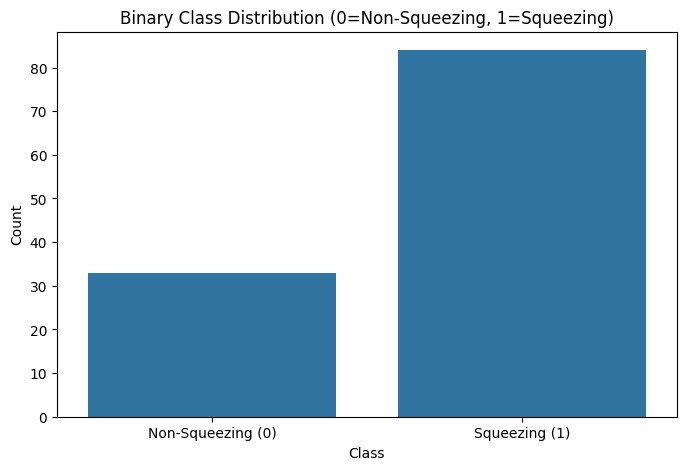

In [8]:
# Binary class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Binary_Class', data=df)
plt.title('Binary Class Distribution (0=Non-Squeezing, 1=Squeezing)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Squeezing (0)', 'Squeezing (1)'])
plt.show()

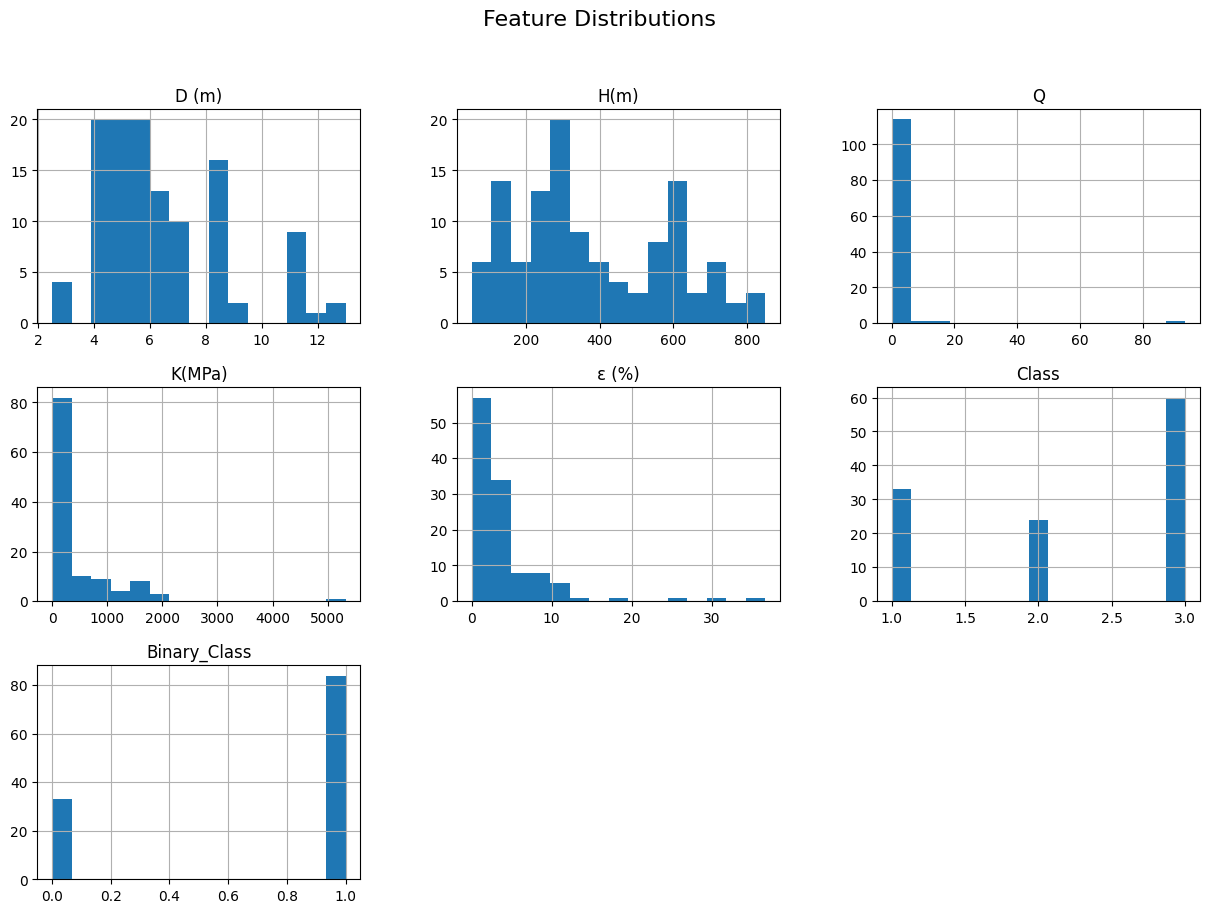

In [9]:
# Feature distributions
df.hist(bins=15, figsize=(15, 10))
plt.suptitle('Feature Distributions', fontsize=16)
plt.show()

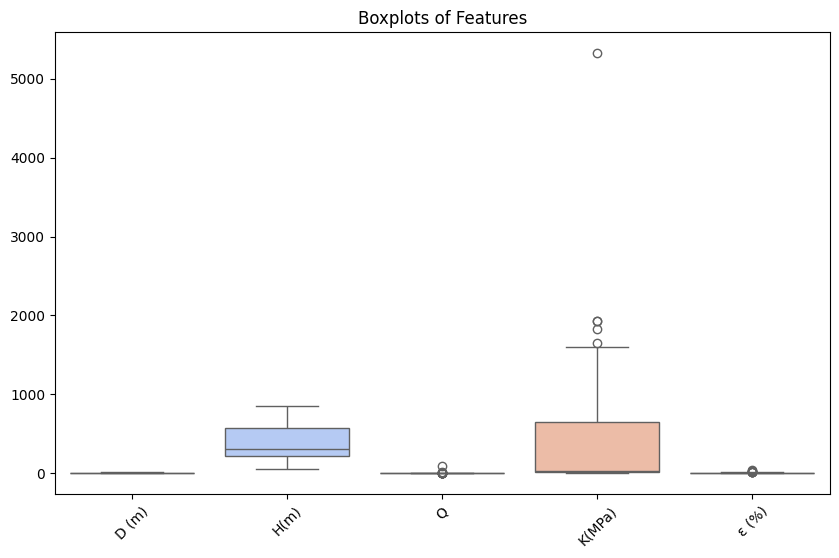

In [10]:
# Boxplots
plt.figure(figsize=(10, 6))
sns.boxplot(data=df.drop(columns=['Class', 'Binary_Class']), palette='coolwarm')
plt.title('Boxplots of Features')
plt.xticks(rotation=45)
plt.show()

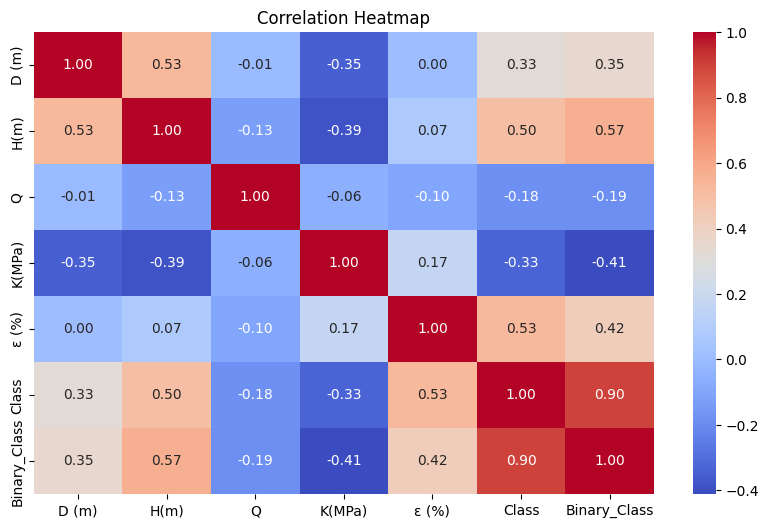

In [11]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Heatmap')
plt.show()

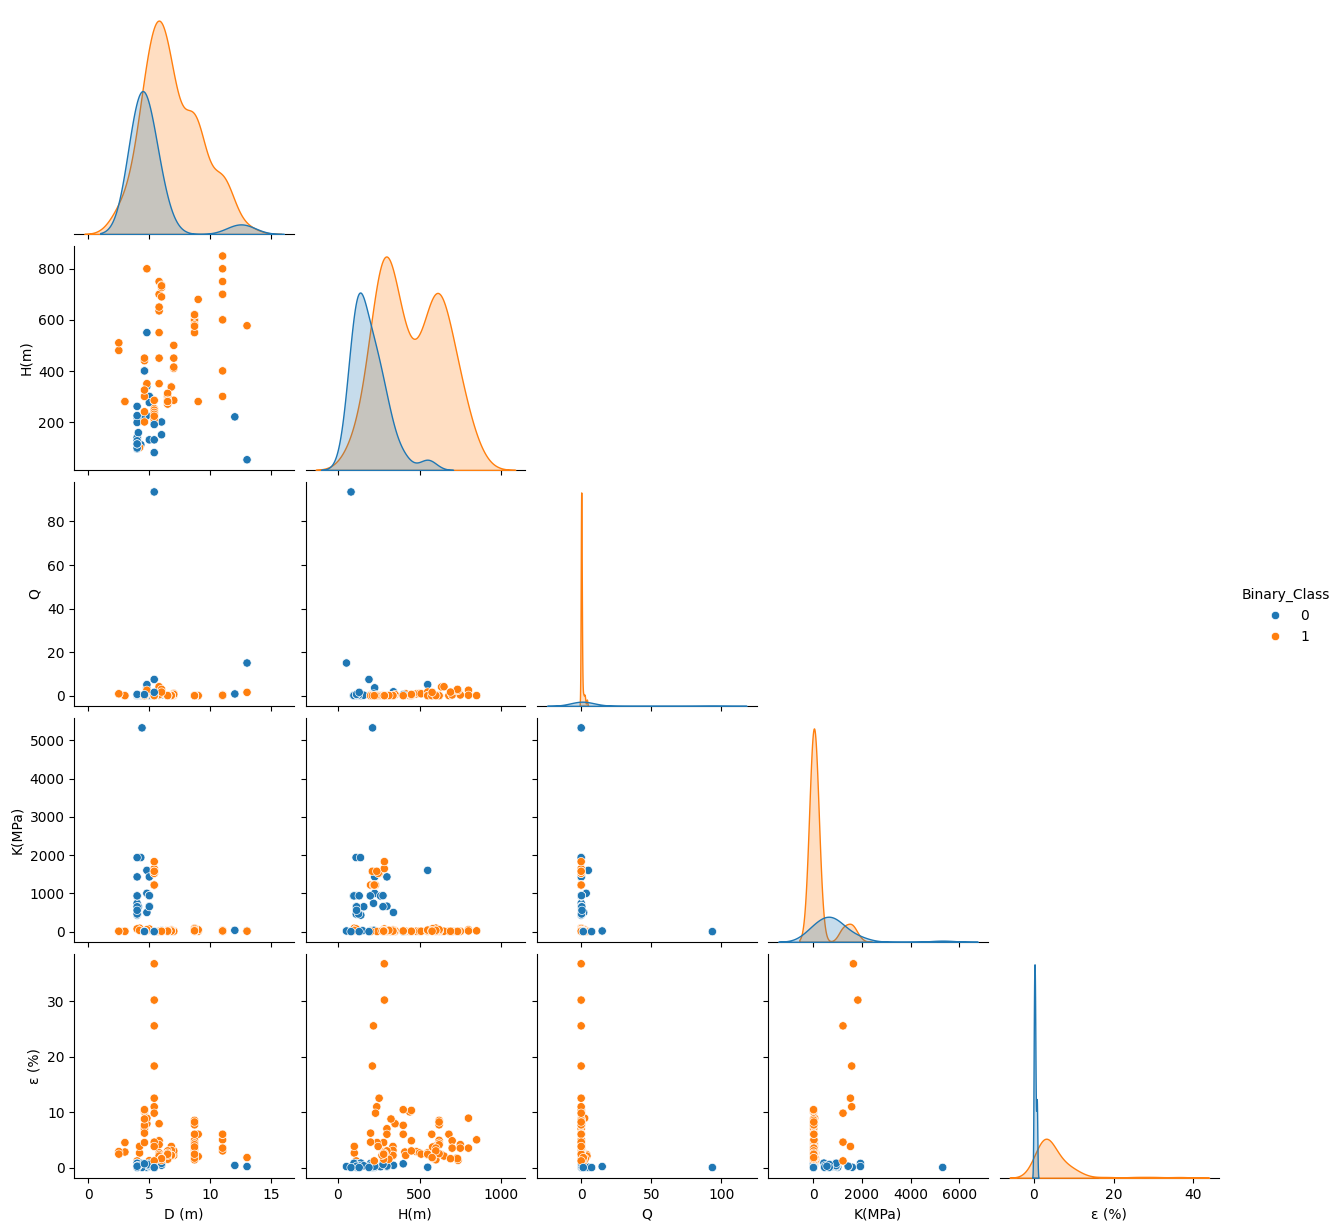

In [12]:
# Pairplot by binary class
sns.pairplot(df.drop(columns=['Class']), hue='Binary_Class', diag_kind='kde', corner=True)
plt.show()

## 5. Feature Engineering and Train-Test Split

In [13]:
# Prepare features and binary target
X = df[["D (m)", "H(m)", "Q", "K(MPa)"]]
y = df["Binary_Class"]

print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("Class distribution:", y.value_counts())

Features shape: (117, 4)
Target shape: (117,)
Class distribution: Binary_Class
1    84
0    33
Name: count, dtype: int64


In [14]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)
print("Training class distribution:\n", y_train.value_counts())
print("Test class distribution:\n", y_test.value_counts())

Training set size: (93, 4)
Test set size: (24, 4)
Training class distribution:
 Binary_Class
1    67
0    26
Name: count, dtype: int64
Test class distribution:
 Binary_Class
1    17
0     7
Name: count, dtype: int64


## 6. Handle Class Imbalance with SMOTE

In [15]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Original training data shape:", X_train.shape)
print("SMOTE balanced training data shape:", X_train_smote.shape)
print("\nOriginal class distribution:")
print(y_train.value_counts())
print("\nSMOTE balanced class distribution:")
print(y_train_smote.value_counts())

Original training data shape: (93, 4)
SMOTE balanced training data shape: (134, 4)

Original class distribution:
Binary_Class
1    67
0    26
Name: count, dtype: int64

SMOTE balanced class distribution:
Binary_Class
1    67
0    67
Name: count, dtype: int64


## 7. Hyperparameter Tuning with RandomizedSearchCV

In [16]:
# Scale data
scaler = StandardScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# Define hyperparameter distribution
param_dist = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    SVC(class_weight='balanced', random_state=42),
    param_dist,
    n_iter=30,
    cv=5,
    scoring='roc_auc',  # Use ROC-AUC for binary classification
    n_jobs=-1,
    verbose=1,
    random_state=42
)

print("Starting randomized hyperparameter search...")
random_search.fit(X_train_smote_scaled, y_train_smote)

print(f"\nBest parameters: {random_search.best_params_}")
print(f"Best cross-validation ROC-AUC score: {random_search.best_score_:.4f}")

Starting randomized hyperparameter search...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best parameters: {'kernel': 'rbf', 'gamma': 1, 'C': 100}
Best cross-validation ROC-AUC score: 0.9868


## 8. Train Final Model with Best Parameters

In [17]:
# Train final model with probability enabled
best_params = random_search.best_params_
final_model = SVC(
    **best_params,
    class_weight='balanced',
    probability=True,
    random_state=42
)
final_model.fit(X_train_smote_scaled, y_train_smote)

print("Trained final model with best params:", best_params)

Trained final model with best params: {'kernel': 'rbf', 'gamma': 1, 'C': 100}


## 9. Model Evaluation - Basic Metrics

In [18]:
# Make predictions
y_pred = final_model.predict(X_test_scaled)
y_pred_proba = final_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Squeezing', 'Squeezing']))

Accuracy: 1.0
Balanced Accuracy: 1.0
ROC-AUC Score: 1.0

Confusion Matrix:
[[ 7  0]
 [ 0 17]]

Classification Report:
               precision    recall  f1-score   support

Non-Squeezing       1.00      1.00      1.00         7
    Squeezing       1.00      1.00      1.00        17

     accuracy                           1.00        24
    macro avg       1.00      1.00      1.00        24
 weighted avg       1.00      1.00      1.00        24



## 10. Advanced Visualizations

### 10.1 Confusion Matrix

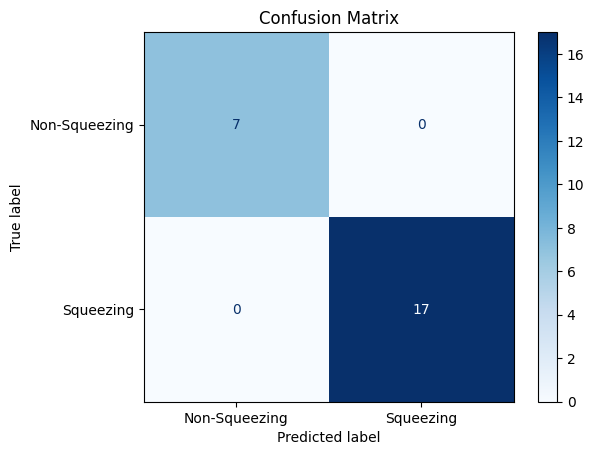

In [19]:
# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Squeezing', 'Squeezing'])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

### 10.2 ROC Curve

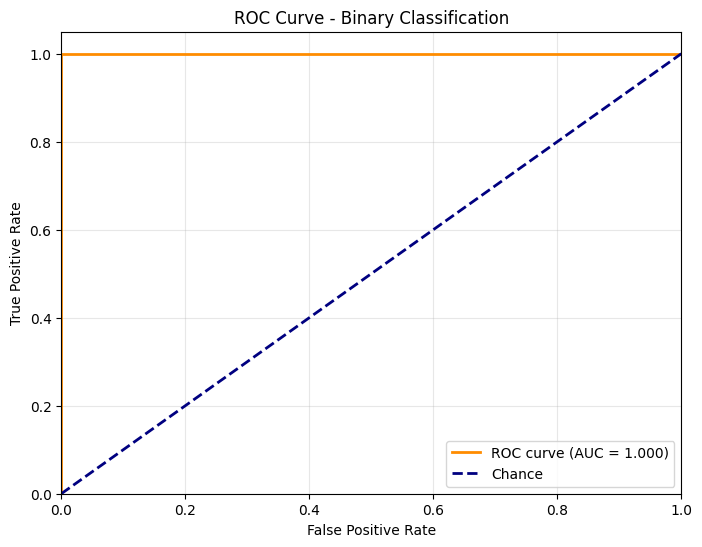

In [20]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Binary Classification')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

### 10.3 Precision-Recall Curve

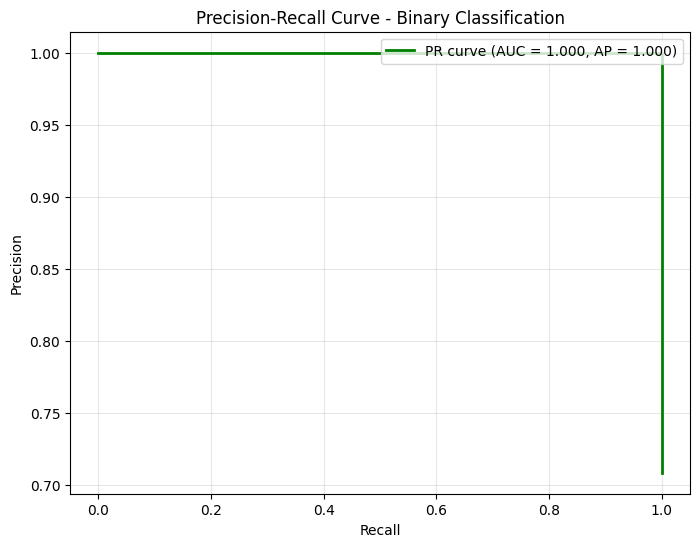

In [21]:
# Precision-Recall curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
avg_precision = average_precision_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.3f}, AP = {avg_precision:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Binary Classification')
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)
plt.show()

### 10.4 Feature Importance (Permutation)

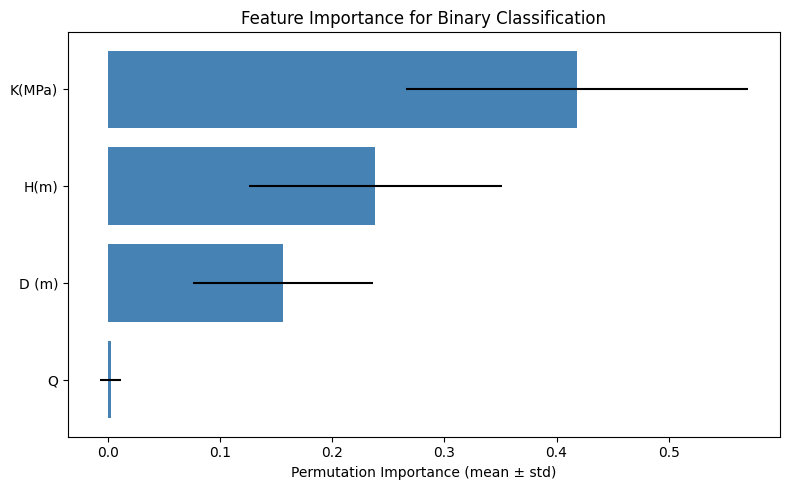

In [22]:
# Permutation feature importance
feature_names = X.columns
perm = permutation_importance(
    final_model,
    X_test_scaled,
    y_test,
    n_repeats=20,
    random_state=42,
    scoring='roc_auc'
)

mean_importance = perm.importances_mean
std_importance = perm.importances_std
idx = np.argsort(mean_importance)

plt.figure(figsize=(8, 5))
plt.barh(np.array(feature_names)[idx], mean_importance[idx], xerr=std_importance[idx], color="steelblue")
plt.xlabel("Permutation Importance (mean ± std)")
plt.title("Feature Importance for Binary Classification")
plt.tight_layout()
plt.show()

### 10.5 Calibration Curve

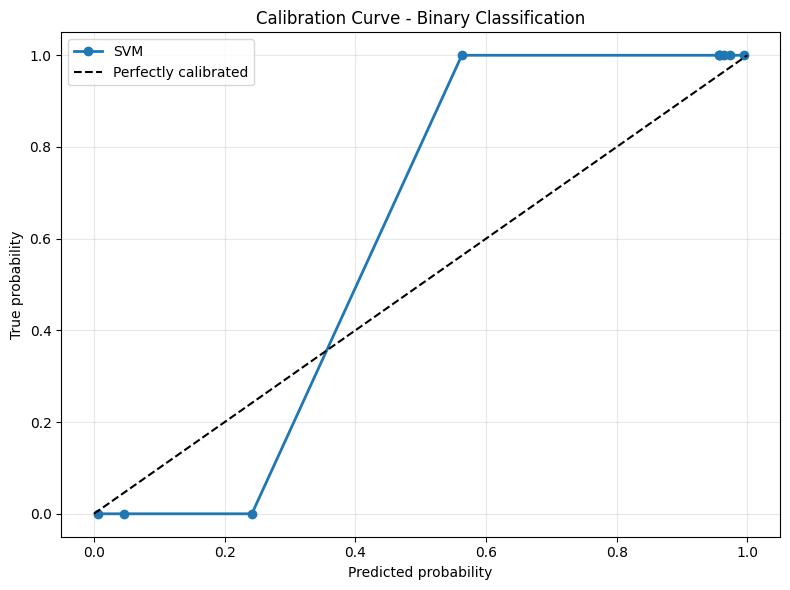

In [23]:
# Calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10, strategy='quantile')

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label='SVM')
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
plt.xlabel('Predicted probability')
plt.ylabel('True probability')
plt.title('Calibration Curve - Binary Classification')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 10.6 Decision Boundary (2D projection using top 2 features)

Top 2 features for decision boundary: ['H(m)', 'K(MPa)']


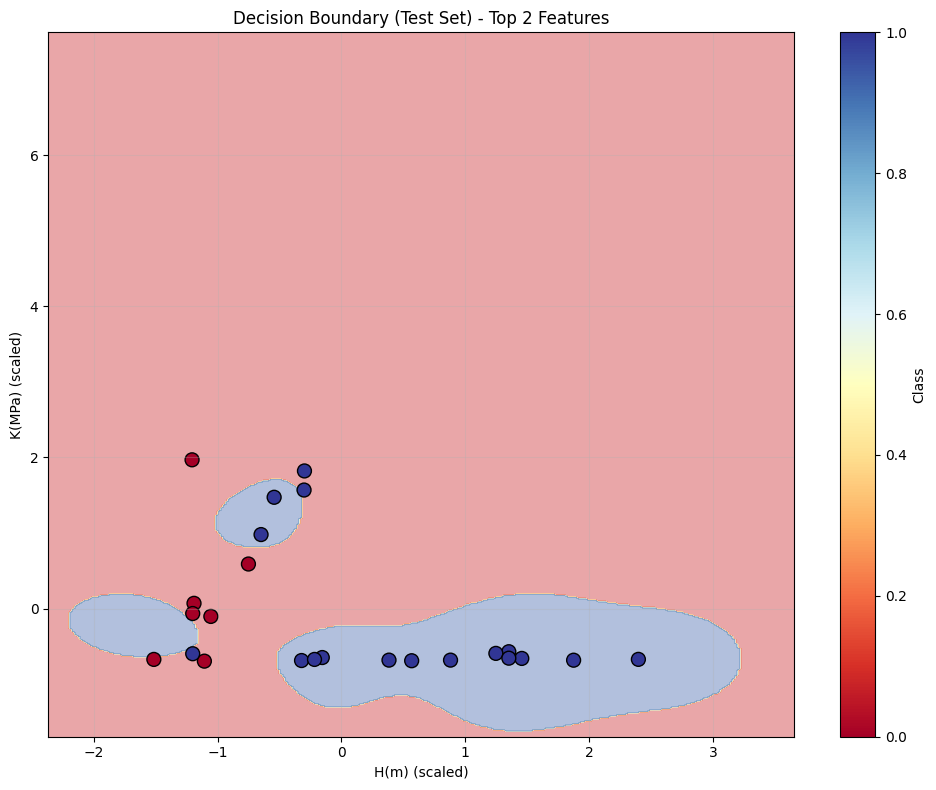

In [24]:
# Get top 2 most important features
top_2_features_idx = np.argsort(mean_importance)[-2:]
top_2_features = feature_names[top_2_features_idx]

print(f"Top 2 features for decision boundary: {top_2_features.tolist()}")

# Train model on only top 2 features for visualization
X_train_2d = X_train_smote_scaled[:, top_2_features_idx]
X_test_2d = X_test_scaled[:, top_2_features_idx]

model_2d = SVC(**best_params, class_weight='balanced', random_state=42)
model_2d.fit(X_train_2d, y_train_smote)

# Create mesh
h = 0.02
x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict on mesh
Z = model_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')
scatter = plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_test, cmap='RdYlBu', edgecolors='k', s=100)
plt.xlabel(f'{top_2_features[0]} (scaled)')
plt.ylabel(f'{top_2_features[1]} (scaled)')
plt.title('Decision Boundary (Test Set) - Top 2 Features')
plt.colorbar(scatter, label='Class')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 11. Summary and Conclusions

In [25]:
# Summary statistics
summary_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Balanced Accuracy', 'ROC-AUC', 'Average Precision'],
    'Score': [
        accuracy_score(y_test, y_pred),
        balanced_accuracy_score(y_test, y_pred),
        roc_auc_score(y_test, y_pred_proba),
        average_precision_score(y_test, y_pred_proba)
    ]
})

print("="*50)
print("BINARY CLASSIFICATION SUMMARY")
print("="*50)
print("\nPerformance Metrics:")
print(summary_df.to_string(index=False))
print("\nOptimal Hyperparameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")
print("\nFeature Importance (Highest to Lowest):")
importance_df = pd.DataFrame({
    'Feature': feature_names[idx],
    'Importance': mean_importance[idx]
}).sort_values('Importance', ascending=False)
print(importance_df.to_string(index=False))
print("\nClass Distribution:")
print(f"  Non-Squeezing (0): {sum(y == 0)} samples")
print(f"  Squeezing (1): {sum(y == 1)} samples")
print("="*50)

BINARY CLASSIFICATION SUMMARY

Performance Metrics:
           Metric  Score
         Accuracy    1.0
Balanced Accuracy    1.0
          ROC-AUC    1.0
Average Precision    1.0

Optimal Hyperparameters:
  kernel: rbf
  gamma: 1
  C: 100

Feature Importance (Highest to Lowest):
Feature  Importance
 K(MPa)    0.418067
   H(m)    0.238235
  D (m)    0.155882
      Q    0.002101

Class Distribution:
  Non-Squeezing (0): 33 samples
  Squeezing (1): 84 samples
